# Jupyter notebook
## Data cleaning and transformation
Import the TfL cycling data. Check for duplicates and null values, which are removed.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

In [2]:
trip_df = pd.read_excel("datasets/Central London (area).xlsx")
trip_df.head()

,Survey wave (calendar quarter),Equivalent financial quarter,Site ID,Location,Survey date,Weather,Time,Period,Direction,Start hour,Start minute,Number of private cycles,Number of cycle hire bikes,Total cycles
0,2014 Q1 (January-March),2013-14 Q4,CENCY001,Millbank (south of Thorney Street),2014-01-24 00:00:00,Dry,0600 - 0615,Early Morning (06:00-07:00),Northbound,6,0,0.0,0.0,0
1,2014 Q1 (January-March),2013-14 Q4,CENCY001,Millbank (south of Thorney Street),2014-01-24 00:00:00,Dry,0615 - 0630,Early Morning (06:00-07:00),Northbound,6,15,15.0,0.0,15
2,2014 Q1 (January-March),2013-14 Q4,CENCY001,Millbank (south of Thorney Street),2014-01-24 00:00:00,Dry,0630 - 0645,Early Morning (06:00-07:00),Northbound,6,30,35.0,0.0,35
3,2014 Q1 (January-March),2013-14 Q4,CENCY001,Millbank (south of Thorney Street),2014-01-24 00:00:00,Dry,0645 - 0700,Early Morning (06:00-07:00),Northbound,6,45,59.0,2.0,61
4,2014 Q1 (January-March),2013-14 Q4,CENCY001,Millbank (south of Thorney Street),2014-01-24 00:00:00,Dry,0700 - 0715,AM peak (07:00-10:00),Northbound,7,0,73.0,0.0,73


In [3]:
print(trip_df.duplicated().value_counts())
trip_df.isnull().sum()

False    758163
dtype: int64


Survey wave (calendar quarter)        0
Equivalent financial quarter          0
Site ID                               0
Location                              0
Survey date                       10156
Weather                           11834
Time                                  0
Period                                0
Direction                             0
Start hour                            0
Start minute                          0
Number of private cycles             64
Number of cycle hire bikes           64
Total cycles                          0
dtype: int64

In [4]:
trip_df = trip_df.dropna()
trip_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 743317 entries, 0 to 758162
Data columns (total 14 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Survey wave (calendar quarter)  743317 non-null  object 
 1   Equivalent financial quarter    743317 non-null  object 
 2   Site ID                         743317 non-null  object 
 3   Location                        743317 non-null  object 
 4   Survey date                     743317 non-null  object 
 5   Weather                         743317 non-null  object 
 6   Time                            743317 non-null  object 
 7   Period                          743317 non-null  object 
 8   Direction                       743317 non-null  object 
 9   Start hour                      743317 non-null  int64  
 10  Start minute                    743317 non-null  int64  
 11  Number of private cycles        743317 non-null  float64
 12  Number of cycle 

The survey date needs to be a datetime object and some columns can be removed. I'll see how many locations are monitored first. 

In [5]:
print('Number of survey sites:', trip_df['Site ID'].nunique())

trip_df['Survey date'] = pd.to_datetime(trip_df['Survey date'], errors='coerce')
trip_df['Survey date'].isnull().sum()

#Produced 256 instances of NaT
trip_df['Survey date'] = trip_df['Survey date'].dropna()

trip_df = trip_df.drop(['Equivalent financial quarter', 'Site ID', 'Location', 'Direction'], axis=1)

Number of survey sites: 210


To make the data more useable I'll change the "Survey wave" column into a "Quarter" integer and add "Year" and "Is_weekday" columns.

In [6]:
trip_df.rename(columns={'Survey wave (calendar quarter)': 'Quarter'}, inplace=True)
trip_df['Quarter'] = trip_df['Quarter'].str.extract('\\sQ([0-9])')

trip_df['Year'] = trip_df['Survey date'].dt.year
trip_df['Is_weekday'] = (trip_df['Survey date'].dt.weekday < 5).astype(int)

trip_df.head()

,Quarter,Survey date,Weather,Time,Period,Start hour,Start minute,Number of private cycles,Number of cycle hire bikes,Total cycles,Year,Is_weekday
0,1,2014-01-24,Dry,0600 - 0615,Early Morning (06:00-07:00),6,0,0.0,0.0,0,2014.0,1
1,1,2014-01-24,Dry,0615 - 0630,Early Morning (06:00-07:00),6,15,15.0,0.0,15,2014.0,1
2,1,2014-01-24,Dry,0630 - 0645,Early Morning (06:00-07:00),6,30,35.0,0.0,35,2014.0,1
3,1,2014-01-24,Dry,0645 - 0700,Early Morning (06:00-07:00),6,45,59.0,2.0,61,2014.0,1
4,1,2014-01-24,Dry,0700 - 0715,AM peak (07:00-10:00),7,0,73.0,0.0,73,2014.0,1


There are 282 different weather descriptors used in the TfL data. With the large dataset I can ignore the little used (sub 200 count) descriptors and change the rest to either 'Wet' or 'Dry', omitting anything ambiguous.<br>
I then changed 'Weather' to a more useful boolean: 0 = dry, 1 = wet

In [7]:
pd.set_option('display.max_rows', 12)
print('Number of weather labels:', (trip_df['Weather'].nunique()))
print('Number of records:', trip_df['Weather'].value_counts().sum())
print(trip_df['Weather'].value_counts())

Number of weather labels: 282
Number of records: 743317
Dry                   618381
Wet                    77522
Fine                   18846
Rain                    5408
Cloudy                  4394
                       ...  
Wet And Very Windy         2
Drizzle/rain               2
Shower/wet                 2
Deluge                     2
Windy/cloudy               2
Name: Weather, Length: 282, dtype: int64


In [8]:
trip_df['Weather'] = trip_df['Weather'].replace({'Rain': 'Wet', 'Drizzle': 'Wet', 'Light Rain': 'Wet', 'Wet ': 'Wet', 'Cold/rain': 'Wet', 'Lt Rain': 'Wet', 'Rain/wind': 'Wet'})
trip_df['Weather'] = trip_df['Weather'].replace({'Fine': 'Dry', 'Cloudy': 'Dry', 'Sunny': 'Dry', 'Fair': 'Dry', 'Dry/sunny': 'Dry', 'Windy': 'Dry', 'Cold': 'Dry', 'Dry/hot': 'Dry'})
print(trip_df['Weather'].value_counts())

Dry                    646359
Wet                     86148
Damp                      639
Wet/dry                   422
Dry/wet                   298
                        ...  
Road Drying Sun Out         2
Drizzle/rain                2
Cloudy/drizzle              2
Dry 3/4 Dry                 2
Fine (windy)                2
Name: Weather, Length: 267, dtype: int64


In [9]:
trip_df['Weather'] = trip_df['Weather'].replace({'Dry': int(0), 'Wet': int(1)})
trip_df['Weather'] = pd.to_numeric(trip_df['Weather'], errors='coerce')
trip_df=trip_df.dropna(subset=['Weather'])
trip_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 732507 entries, 0 to 758162
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Quarter                     732507 non-null  object        
 1   Survey date                 732251 non-null  datetime64[ns]
 2   Weather                     732507 non-null  float64       
 3   Time                        732507 non-null  object        
 4   Period                      732507 non-null  object        
 5   Start hour                  732507 non-null  int64         
 6   Start minute                732507 non-null  int64         
 7   Number of private cycles    732507 non-null  float64       
 8   Number of cycle hire bikes  732507 non-null  float64       
 9   Total cycles                732507 non-null  int64         
 10  Year                        732251 non-null  float64       
 11  Is_weekday                  732507 non-

There is a small number of entries dated June 2020 in the third quarter of that year, which need to be removed

In [10]:
mask_0620 = (trip_df['Survey date'].dt.year == 2020) & (trip_df['Survey date'].dt.month == 6)
trip_df = trip_df[~mask_0620]

## Overall analysis
This is complicated by there being gaps in the data from TfL. Q2 2020 (first lockdow) is synthetic, so best left out in this analysis. Then Q4 2020 and Q1 2021 are both missing completely. A check of the variance in mean total monthly cycle trips by year clearly shows the difference COVID made. Plotting by quarter gives an expected use pattern.

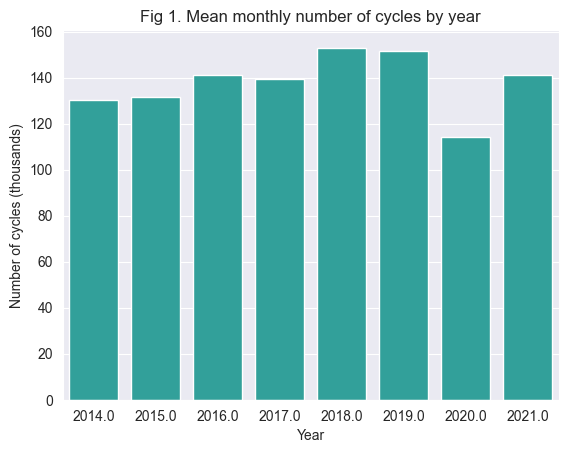

In [11]:

trip_df['Year'] = trip_df['Survey date'].dt.year
trip_df['Month'] = trip_df['Survey date'].dt.month

# Group by 'Year' and 'Month' and calculate the sum of 'Total cycles' for each month of each year
trip_df_grouped_month = trip_df.groupby(['Year', 'Month'])['Total cycles'].sum().reset_index()

# Group by 'Year' and calculate the mean of 'Total cycles' for each year
trip_df_grouped_year_month_avg = trip_df_grouped_month.groupby('Year')['Total cycles'].mean().reset_index()

trip_df_grouped_year_month_avg['Total cycles (thousands)'] = trip_df_grouped_year_month_avg['Total cycles'] / 1000


sns.light_palette("seagreen")
sns.barplot(x='Year', y='Total cycles (thousands)', data=trip_df_grouped_year_month_avg, color="lightseagreen")
plt.title('Fig 1. Mean monthly number of cycles by year')
plt.ylabel('Number of cycles (thousands)')
plt.show()

In [12]:
print('Average monthly cycles 2019:', trip_df_grouped_year_month_avg['Total cycles'][trip_df_grouped_year_month_avg['Year'] == 2019].values)
print('Average monthly cycles 2020:', trip_df_grouped_year_month_avg['Total cycles'][trip_df_grouped_year_month_avg['Year'] == 2020].values)

Average monthly cycles 2019: [151533.5]
Average monthly cycles 2020: [114379.85714286]


This is a drop of 32.5%. 
London Underground passenger journeys dropped from 1,337 million in financial year 2019/20 to 296.1m in 2020/21 – a 77.9% drop.<br> 
Source TfL via Statista https://www.statista.com/statistics/304852/passenger-journeys-on-the-london-underground/

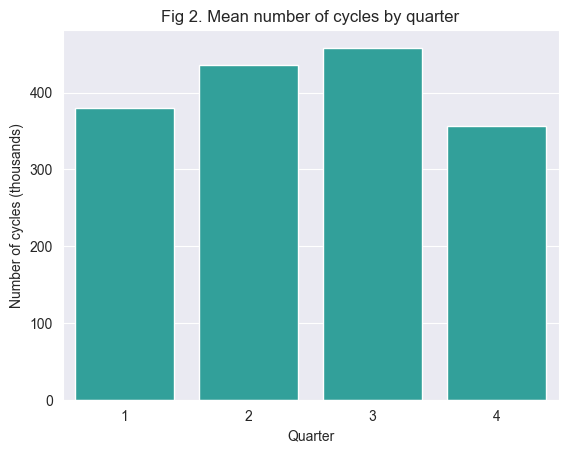

In [13]:

trip_df['Year'] = trip_df['Survey date'].dt.year
trip_df['Quarter'] = trip_df['Survey date'].dt.quarter

# Group by 'Year' and 'Quarter' and calculate the sum of 'Total cycles' for each quarter of each year
trip_df_grouped_quarter = trip_df.groupby(['Year', 'Quarter'])['Total cycles'].sum().reset_index()

# Group by 'Quarter' and calculate the mean of 'Total cycles' for each quarter
trip_df_grouped_quarter_avg  = trip_df_grouped_quarter.groupby('Quarter')['Total cycles'].mean().reset_index()

trip_df_grouped_quarter_avg['Total cycles (thousands)'] = trip_df_grouped_quarter_avg['Total cycles'] / 1000
trip_df_grouped_quarter_avg['Quarter'] = trip_df_grouped_quarter_avg['Quarter'].astype(int)
sns.barplot(x='Quarter', y='Total cycles (thousands)', data=trip_df_grouped_quarter_avg, color="lightseagreen")
plt.title('Fig 2. Mean number of cycles by quarter')
plt.ylabel('Number of cycles (thousands)')
plt.show()



## Cycling numbers and weather
Load the Open Meteo weather data and remove the weathercode as the TfL data may include more granular wet and dry information. It will be at least as detailed as Open Meteo's.

Assuming that the majority of decisions about commuting by bike will be made during the morning rush hour – "AM peak (07:00-10:00)" – I will use the temperature at 8am, rounded to the nearest integer. Trip data is limited to weekdays for commuting analysis.

In [14]:
weather_df = pd.read_csv('datasets/hourly_weather.csv')
weather_df.head()

,time,temperature,relative_humidity,precipitation,weathercode
0,2014-01-24T00:00,1.4,90,0.0,1
1,2014-01-24T01:00,0.9,92,0.0,2
2,2014-01-24T02:00,0.4,93,0.0,3
3,2014-01-24T03:00,0.1,94,0.0,2
4,2014-01-24T04:00,0.2,95,0.0,3


In [15]:
weather_df = weather_df.drop(['weathercode'], axis= 1)
weather_df['time'] = pd.to_datetime(weather_df['time'])

weather_df_filtered = weather_df.loc[weather_df['time'].dt.hour == 8].copy()
weather_df_filtered['time'] = weather_df_filtered['time'].dt.floor('d')
weather_df_filtered.rename(columns= {'time': 'Survey date'}, inplace=True)

weather_df_filtered['temp_integer'] = weather_df_filtered['temperature'].round().astype(int)
print(weather_df_filtered.head())


    Survey date  temperature  relative_humidity  precipitation  temp_integer
8    2014-01-24          1.4                 97            0.0             1
32   2014-01-25          7.1                 99            0.0             7
56   2014-01-26          3.6                 87            0.0             4
80   2014-01-27          1.6                 86            0.0             2
104  2014-01-28          4.1                 92            0.0             4


Merge the TfL cycle trip and the Open Meteo weather dataframes and then extract the data for <br>
the morning peak on weekdays.

In [16]:
trip_with_temp = pd.merge(trip_df, weather_df_filtered, on= ['Survey date'])

AM_peak_trips = trip_with_temp.loc[(trip_with_temp['Period'] == 'AM peak (07:00-10:00)') & (trip_with_temp['Is_weekday'] == 1)]
AM_peak_trips.describe()

,Quarter,Weather,Start hour,Start minute,Number of private cycles,Number of cycle hire bikes,Total cycles,Year,Is_weekday,Month,temperature,relative_humidity,precipitation,temp_integer
count,135710.000000,135710.000000,135710.000000,135710.000000,135710.000000,135710.000000,135710.00000,135710.000000,135710.0,135710.000000,135710.000000,135710.000000,135710.000000,135710.000000
mean,2.542554,0.118429,8.000251,22.501216,26.808533,3.073488,29.88202,2017.259008,1.0,6.669752,10.513116,84.279758,0.060570,10.506433
std,1.102910,0.323117,0.816557,16.770275,40.459219,4.786411,43.98426,2.189381,0.0,3.423939,5.855693,9.969143,0.232177,5.858665
min,1.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.00000,2014.000000,1.0,1.000000,-6.100000,52.000000,0.000000,-6.000000
25%,2.000000,0.000000,7.000000,15.000000,4.000000,0.000000,5.00000,2015.000000,1.0,4.000000,5.900000,77.000000,0.000000,6.000000
50%,3.000000,0.000000,8.000000,30.000000,13.000000,2.000000,15.00000,2017.000000,1.0,7.000000,11.000000,86.000000,0.000000,11.000000
75%,3.000000,0.000000,9.000000,41.250000,32.000000,4.000000,36.00000,2019.000000,1.0,9.000000,15.300000,93.000000,0.000000,15.000000
max,4.000000,1.000000,9.000000,45.000000,1177.000000,108.000000,1200.00000,2021.000000,1.0,12.000000,25.300000,100.000000,3.100000,25.000000


There appears to be at least one outlier in the number of private cycles, so lets look at a histogram.

In [17]:
sorted_AM_peak_trips = AM_peak_trips.sort_values(by='Number of private cycles', ascending=False)
print(sorted_AM_peak_trips.head(2))

        Quarter Survey date  Weather         Time                 Period  \
561862      3.0  2019-08-13      0.0  0745 - 0800  AM peak (07:00-10:00)   
562739      3.0  2019-09-11      0.0  0830 - 0845  AM peak (07:00-10:00)   

        Start hour  Start minute  Number of private cycles  \
561862           7            45                    1177.0   
562739           8            30                     754.0   

        Number of cycle hire bikes  Total cycles    Year  Is_weekday  Month  \
561862                        23.0          1200  2019.0           1    8.0   
562739                        16.0           770  2019.0           1    9.0   

        temperature  relative_humidity  precipitation  temp_integer  
561862         14.2                 79            0.0            14  
562739         15.6                 80            0.0            16  


<AxesSubplot: xlabel='Number of private cycles', ylabel='Count'>

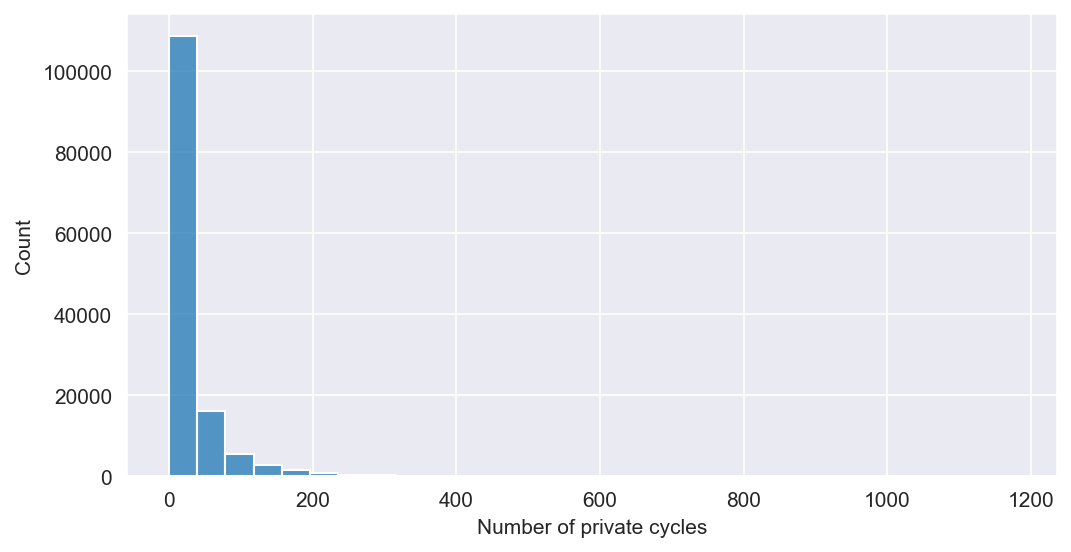

In [18]:
plt.figure(figsize=(8,4), dpi=150)
sns.histplot(data=AM_peak_trips, x="Number of private cycles", bins=30, kde=False)

There is one outlier at 1,177 and a second at 754. It is clear that these do not represent typical commuting patterns. I'll use the IQR to filter the top end.

In [19]:
Q1 = AM_peak_trips['Number of private cycles'].quantile(0.25)
Q3 = AM_peak_trips['Number of private cycles'].quantile(0.75)
IQR = Q3 - Q1

filtered_AM_peak_trips = AM_peak_trips[AM_peak_trips['Number of private cycles'] < (Q3 + IQR * 1.5)].copy()


<AxesSubplot: xlabel='Number of private cycles', ylabel='Count'>

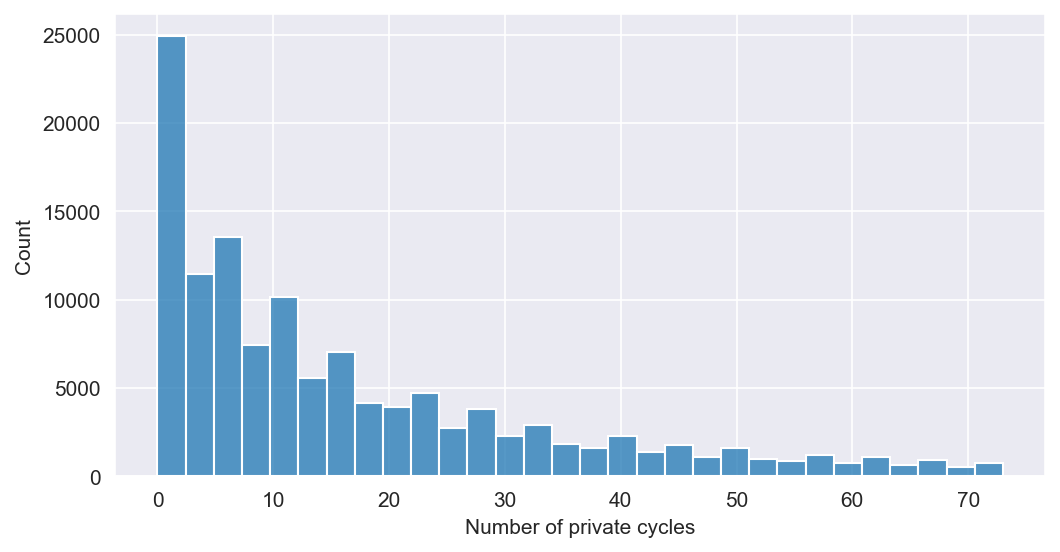

In [20]:
plt.figure(figsize=(8,4), dpi=150)
sns.histplot(data=filtered_AM_peak_trips, x="Number of private cycles", bins=30, kde=False)

Plotting the mean of cycle trips at each location shows large error bars at the extremes, but filtering temperature by Q3 + 1 * IQR has almost no effect on the regression line. The sample size is small at the temperature extremes but the data are valid so will be included.

Text(0, 0.5, 'Number of cycles')

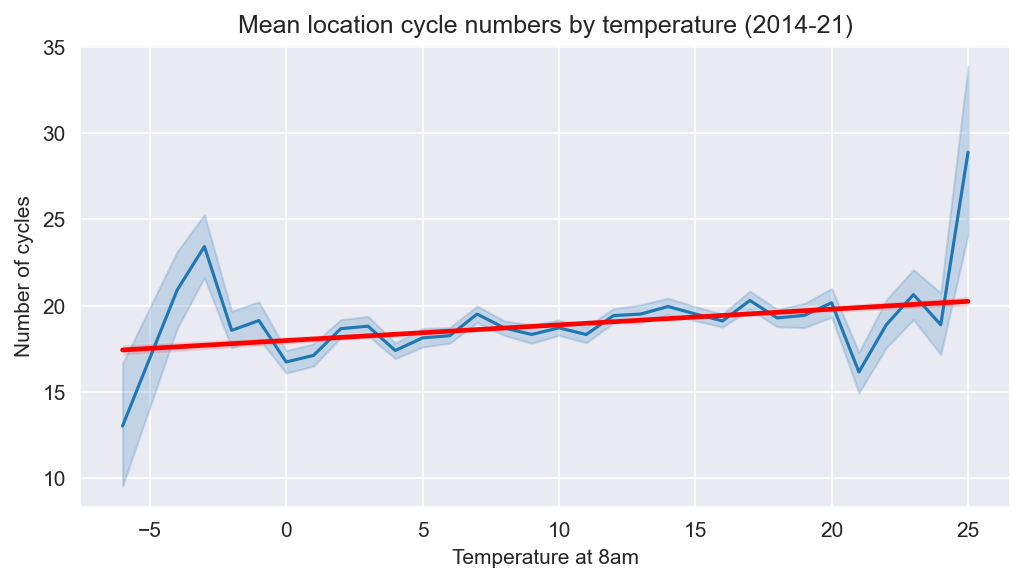

In [21]:

plt.figure(figsize=(8,4), dpi=150)
plt.title('Mean location cycle numbers by temperature (2014-21)')
sns.lineplot(x='temp_integer', y='Total cycles', data=filtered_AM_peak_trips)
sns.regplot(x='temp_integer', y='Total cycles', data=filtered_AM_peak_trips, scatter=False, color='red')
plt.xlabel('Temperature at 8am')
plt.ylabel('Number of cycles')


In [22]:

TQ1 = filtered_AM_peak_trips['temp_integer'].quantile(0.25)
TQ3 = filtered_AM_peak_trips['temp_integer'].quantile(0.75)
TIQR = TQ3 - TQ1

temp_filtered_AM_peak_trips = filtered_AM_peak_trips[~((filtered_AM_peak_trips['temp_integer'] < (TQ1 - 1 * TIQR)) | (filtered_AM_peak_trips['temp_integer'] > (TQ3 + 1 * TIQR)))].copy()


# Calculate the number days at each temperature
days_at_each_temp = weather_df_filtered.groupby('temp_integer')['Survey date'].nunique()
pd.set_option('display.max_rows', 12)
print(days_at_each_temp)

temp_integer
-6      1
-5      2
-4      7
-3     13
-2     31
       ..
 22    24
 23    17
 24     6
 25     2
 26     1
Name: Survey date, Length: 33, dtype: int64


Text(0.5, 1.0, 'Number of cycle counts by temperature')

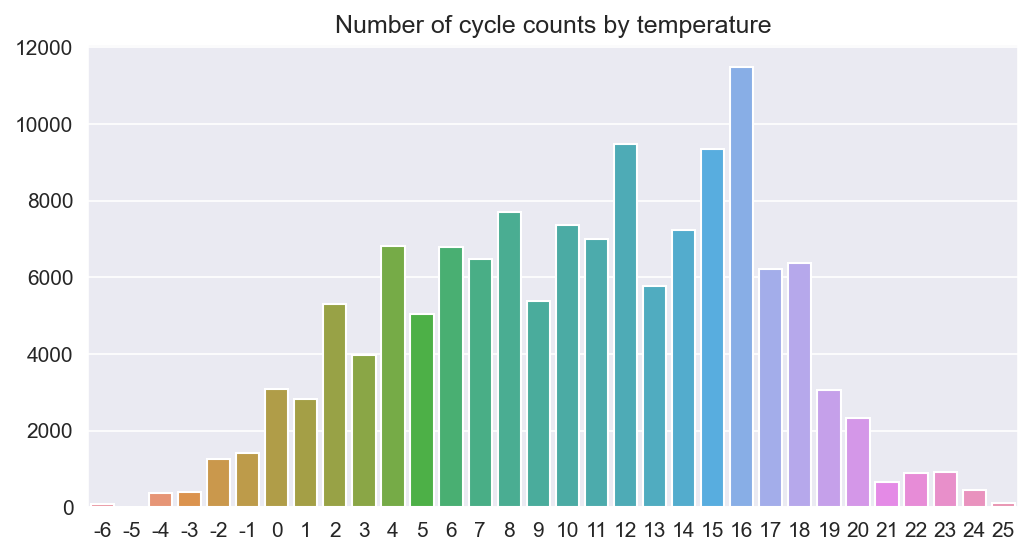

In [23]:
# Counts of temperature readings
temp_value_counts = AM_peak_trips['temp_integer'].value_counts()
#To include -5 in the x ticks as there are no values
temp_value_counts.loc[-5]=0
plt.figure(figsize=(8,4), dpi=150)
sns.barplot(x=temp_value_counts.index, y=temp_value_counts.values)
plt.title('Number of cycle counts by temperature')


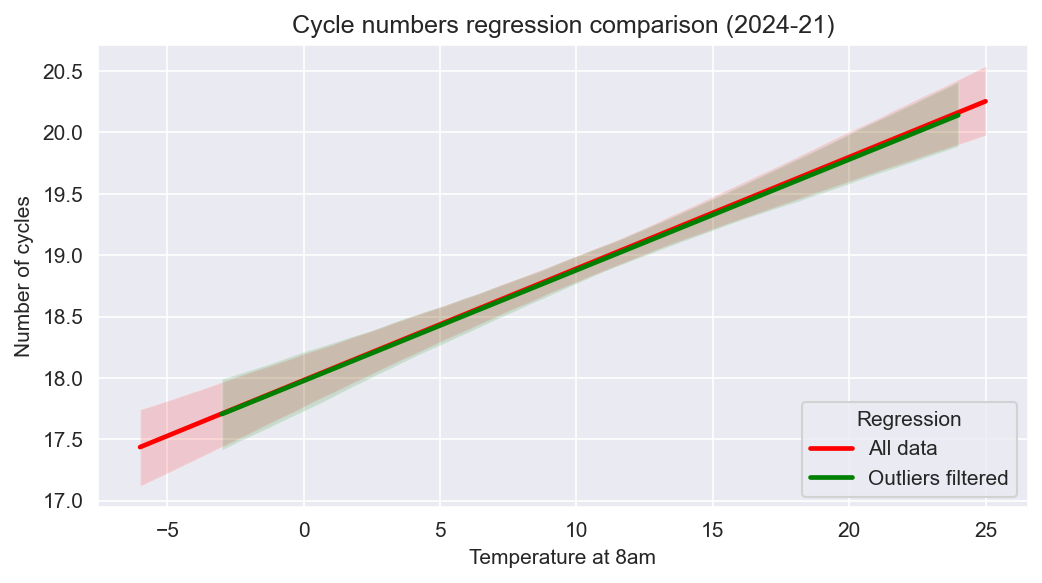

In [24]:
plt.figure(figsize=(8,4), dpi=150)
plt.title('Cycle numbers regression comparison (2024-21)')
sns.regplot(x='temp_integer', y='Total cycles', data=filtered_AM_peak_trips, scatter=False, color='red', label='All data')
sns.regplot(x='temp_integer', y='Total cycles', data=temp_filtered_AM_peak_trips, scatter=False, color='green', label='Outliers filtered')
plt.xlabel('Temperature at 8am')
plt.ylabel('Number of cycles')
plt.legend(title='Regression', loc='lower right')

## Comparison of cycling numbers in dry and wet conditions
Wet weather data needs to be removed to isolate the change that temperature makes.

Text(0, 0.5, 'Number of cycles')

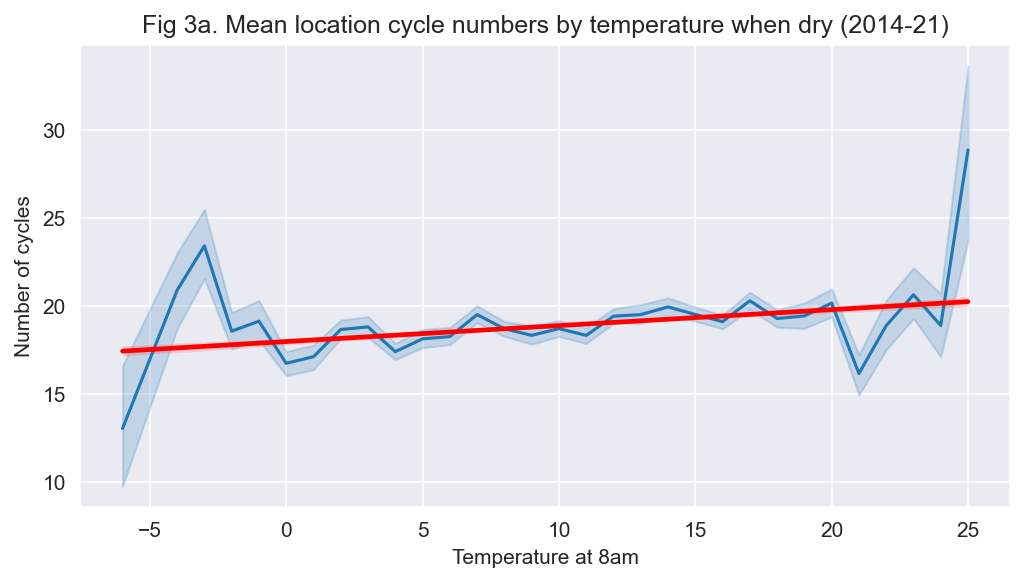

In [25]:
dry_filtered_AM_peak_trips = filtered_AM_peak_trips[filtered_AM_peak_trips['Weather'] == 0]

plt.figure(figsize=(8,4), dpi=150)
plt.title('Fig 3a. Mean location cycle numbers by temperature when dry (2014-21)')
sns.lineplot(x='temp_integer', y='Total cycles', data=filtered_AM_peak_trips)
sns.regplot(x='temp_integer', y='Total cycles', data=filtered_AM_peak_trips, scatter=False, color='red')
plt.xlabel('Temperature at 8am')
plt.ylabel('Number of cycles')


Text(0.5, 0, 'Temperature at 8am')

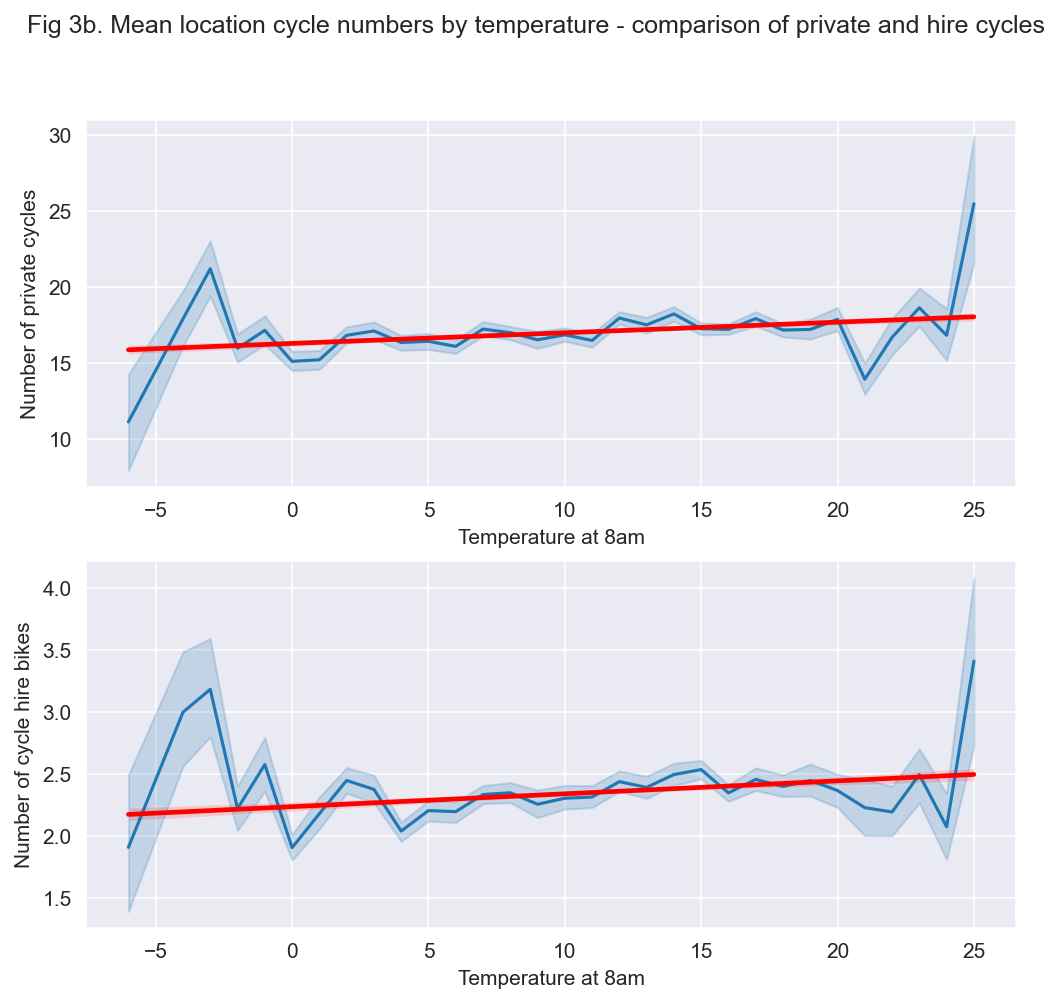

In [26]:
#Compare private and hire bikes

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8,7), dpi=150)

sns.lineplot(x='temp_integer', y='Number of private cycles', data=dry_filtered_AM_peak_trips, ax=axs[0])
sns.regplot(x='temp_integer', y='Number of private cycles', data=dry_filtered_AM_peak_trips, scatter=False, color='red', ax=axs[0])
sns.lineplot(x='temp_integer', y='Number of cycle hire bikes', data=dry_filtered_AM_peak_trips, ax=axs[1])
sns.regplot(x='temp_integer', y='Number of cycle hire bikes', data=dry_filtered_AM_peak_trips, scatter=False, color='red', ax=axs[1])

fig.suptitle('Fig 3b. Mean location cycle numbers by temperature - comparison of private and hire cycles')
axs[0].set_xlabel('Temperature at 8am')
axs[1].set_xlabel('Temperature at 8am')

Text(0, 0.5, 'Number of cycles')

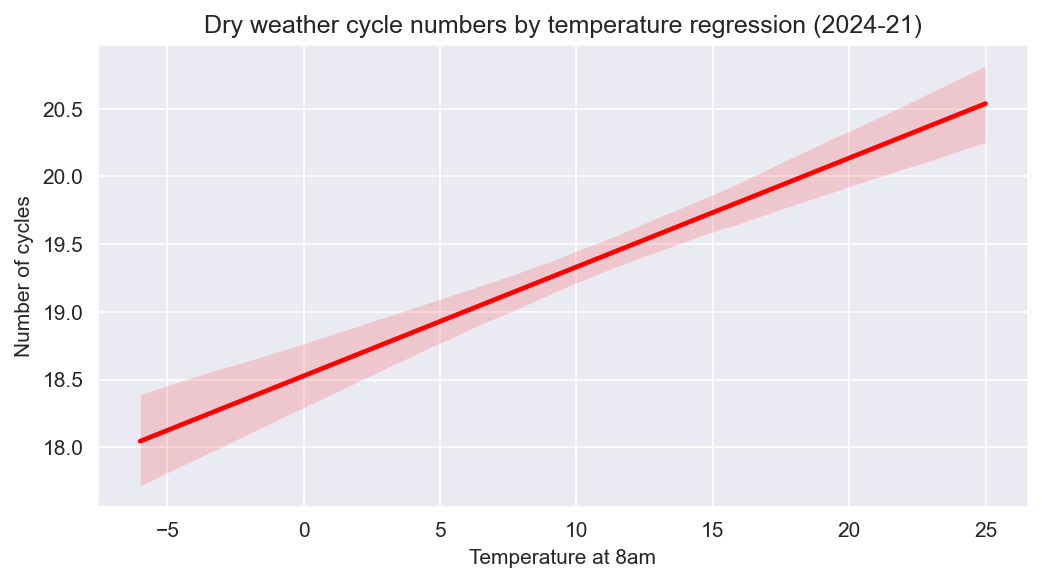

In [27]:

plt.figure(figsize=(8,4), dpi=150)
plt.title('Dry weather cycle numbers by temperature regression (2024-21)')
sns.regplot(x='temp_integer', y='Total cycles', data=dry_filtered_AM_peak_trips, scatter=False, color='red')
plt.xlabel('Temperature at 8am')
plt.ylabel('Number of cycles')


There are more than 7 times as many dry days but we should get a meaningful look at the change in rider numbers on wet weather days by plotting by temperature again. The plot for wet days is non-linear so further exploration was needed.

In [28]:
#How do the numbers of wet and dry days compare?
print(AM_peak_trips['Weather'].value_counts())

0.0    119638
1.0     16072
Name: Weather, dtype: int64


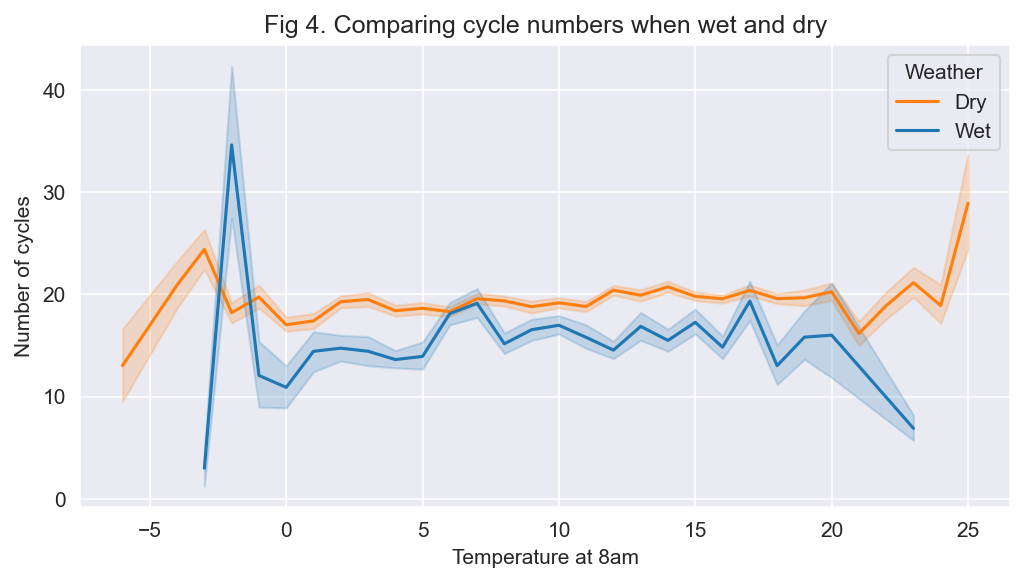

In [29]:
# I'll change the colour palette order so that wet days are plotted in blue
default_palette = sns.color_palette()

# Reverse the order of the first two colors in the list
reversed_first_two_colors = default_palette[:2][::-1] + default_palette[2:]

sns.set_palette(reversed_first_two_colors)
plt.figure(figsize=(8,4), dpi=150)
plt.title('Fig 4. Comparing cycle numbers when wet and dry')
sns.lineplot(x='temp_integer', y='Total cycles', hue= 'Weather', data=filtered_AM_peak_trips)
plt.xlabel('Temperature at 8am')
plt.ylabel('Number of cycles')
plt.legend(title='Weather', loc='upper right')

legend = plt.gca().get_legend()
legend.texts[0].set_text('Dry')
legend.texts[1].set_text('Wet')


Text(0, 0.5, 'Number of cycles')

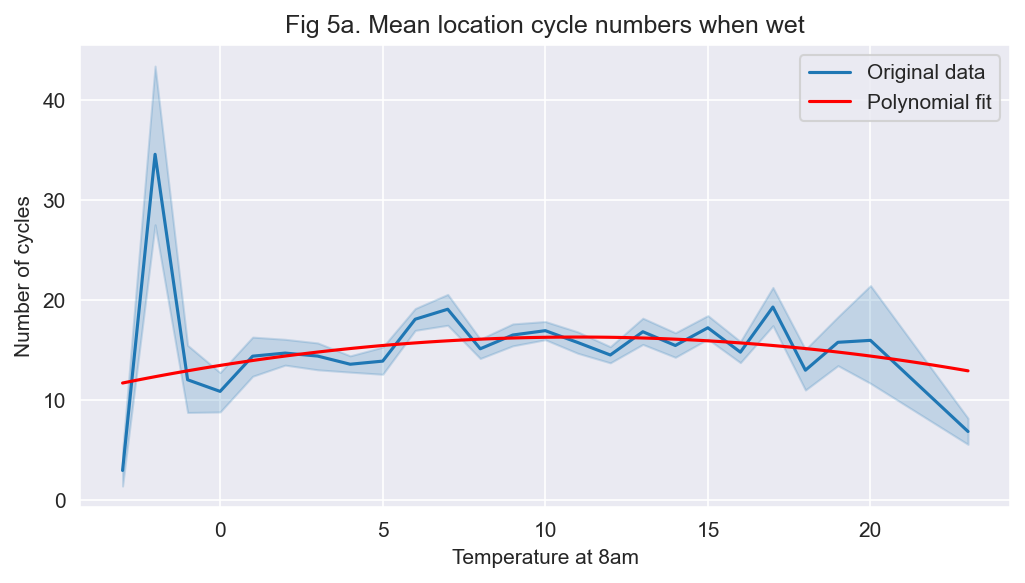

In [30]:
# Polynomial

sns.set_palette(default_palette)
#Select only the rows with 'wet' weather
wet_data = filtered_AM_peak_trips[filtered_AM_peak_trips['Weather'] == 1]

#Fit a 2nd degree polynomial to the data
coefficients = np.polyfit(wet_data['temp_integer'], wet_data['Total cycles'], 2)

#Create a polynomial function with the found coefficients
poly = np.poly1d(coefficients)

#Generate x values
x_poly = np.linspace(wet_data['temp_integer'].min(), wet_data['temp_integer'].max(), 100)

#Generate y values
y_poly = poly(x_poly)

#Plot the original line plot and the polynomial fit
plt.figure(figsize=(8,4), dpi=150)
plt.title('Fig 5a. Mean location cycle numbers when wet')
sns.lineplot(x='temp_integer', y='Total cycles', data=wet_data, label='Original data')
plt.plot(x_poly, y_poly, color='red', label='Polynomial fit')
plt.legend()
plt.xlabel('Temperature at 8am')
plt.ylabel('Number of cycles')



A very good fit. At lower temperatures it's understandable that the combination of cold and wet would be more offputting together, but what about at high temperatures? Could it be that the intensity of rain increases, with thunderstorm type rainfall?

Text(0, 0.5, 'Precipitation')

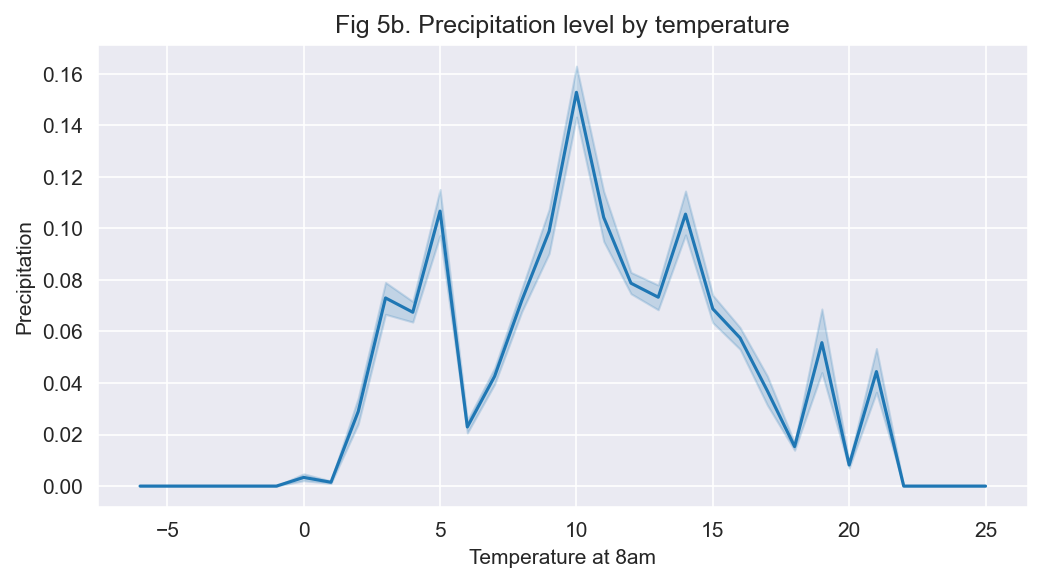

In [31]:
#Let's plot precipitation against temperature for the AM peak

plt.figure(figsize=(8,4), dpi=150)
plt.title('Fig 5b. Precipitation level by temperature')
sns.lineplot(x='temp_integer', y='precipitation', data=filtered_AM_peak_trips)
plt.xlabel('Temperature at 8am')
plt.ylabel('Precipitation')

Preciptation peaks at 10 degrees and drops at higher temps. It could be that wet days when it is hot are not just wet because of precipitation, but also because of perspiration – it's hard not overheat when the weather is hot and humid and not many workplaces have showers. I'll retrieve humidity data from Open Meteo.

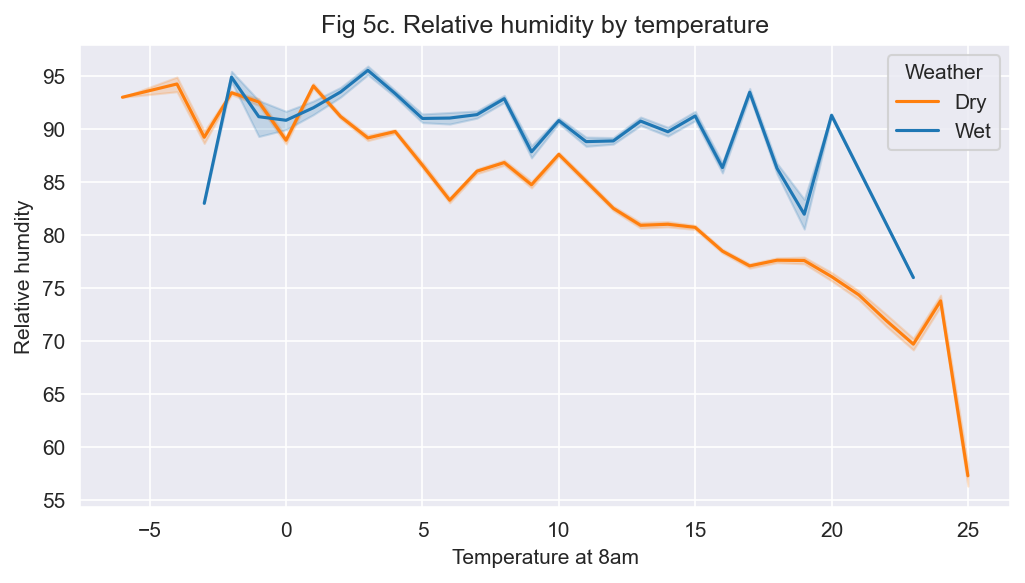

In [32]:
#Plotting humidity against temperature, for wet and dry days

# Create a plot with the reversed palette
sns.set_palette(reversed_first_two_colors)

plt.figure(figsize=(8,4), dpi=150)
plt.title('Fig 5c. Relative humidity by temperature')
sns.lineplot(x='temp_integer', y='relative_humidity', hue='Weather', data=filtered_AM_peak_trips)
plt.xlabel('Temperature at 8am')
plt.ylabel('Relative humdity')

legend = plt.gca().get_legend()
legend.texts[0].set_text('Dry')
legend.texts[1].set_text('Wet')

That does show a higher humidity on wet days for a given temperature and the difference tends to increase as the temperature increases, so this could explain the fall-off in cycling numbers at higher temperatures on wet days.

To look at the effect of wet/dry conditions in isolation we need to separate the data. For analysis of wet weather we need to look at mean reduction in cycle numbers by temperature.

Mean daily Total cycles on dry days: 19.3780833294883
Mean difference in Total cycles on wet and dry days: -4.178128925663486
Percent drop in mean daily Total cycles due to rain: -0.21561105165160904


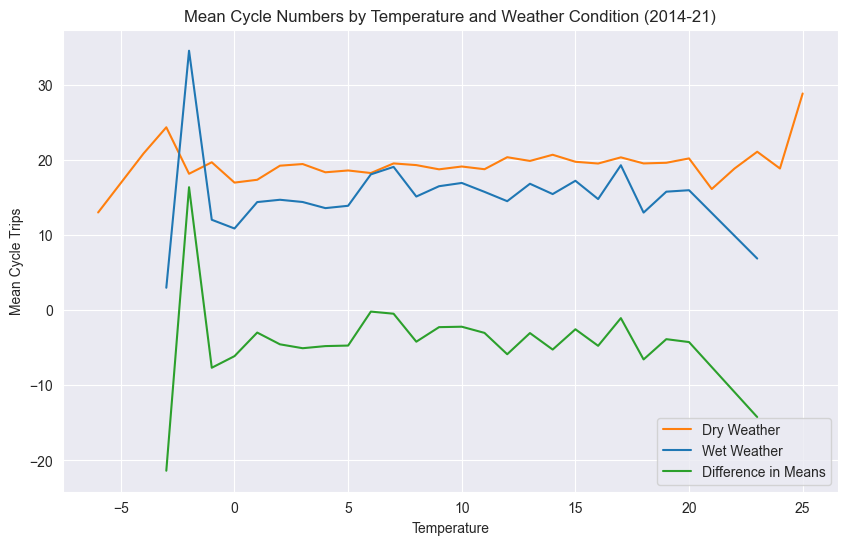

In [33]:

#We'll look at the difference in mean counts of Cycle Trips for wet and dry days with the same temperature
#for all years

df_dry = filtered_AM_peak_trips[filtered_AM_peak_trips['Weather'] == 0]
mean_dry = df_dry.groupby('temp_integer')['Total cycles'].mean().reset_index()

df_wet = filtered_AM_peak_trips[filtered_AM_peak_trips['Weather'] == 1]
mean_wet = df_wet.groupby('temp_integer')['Total cycles'].mean().reset_index()

#Calculate difference in means between wet and dry conditions
mean_difference = mean_wet.merge(mean_dry, on='temp_integer', suffixes=('_wet', '_dry'))
mean_difference['difference'] = mean_difference['Total cycles_wet'] - mean_difference['Total cycles_dry']

#Plotting the results
plt.figure(figsize=(10, 6))

sns.lineplot(x='temp_integer', y='Total cycles', data=mean_dry, label='Dry Weather')
sns.lineplot(x='temp_integer', y='Total cycles', data=mean_wet, label='Wet Weather')

#Difference in means between wet and dry conditions
sns.lineplot(x='temp_integer', y='difference', data=mean_difference, label='Difference in Means')

plt.xlabel('Temperature')
plt.ylabel('Mean Cycle Trips')
plt.title('Mean Cycle Numbers by Temperature and Weather Condition (2014-21)')


#Plotting the difference in means does not add much understanding, but a percentage drop in the overall 
# will be useful
dry_mean = np.mean(df_dry['Total cycles'])
mean_difference = np.mean(mean_difference['difference'])
print('Mean daily Total cycles on dry days:', dry_mean)
print('Mean difference in Total cycles on wet and dry days:', mean_difference)
print('Percent drop in mean daily Total cycles due to rain:', mean_difference/dry_mean)

## The effect of COVID on cycling numbers
Now let's see if people became 'tougher' once the pandemic started, less sensitive to bad weather out of a desire to avoid taking public transport. Due to the missing data from TfL I'll use the first four quarters available after lockdowns started: 2020 Q3 and 2021 Q2-Q4.


To get a figure for the change in cycling numbers due to temperature we should use 'dry' data. 

Text(0, 0.5, 'Number of cycles (2020-21)')

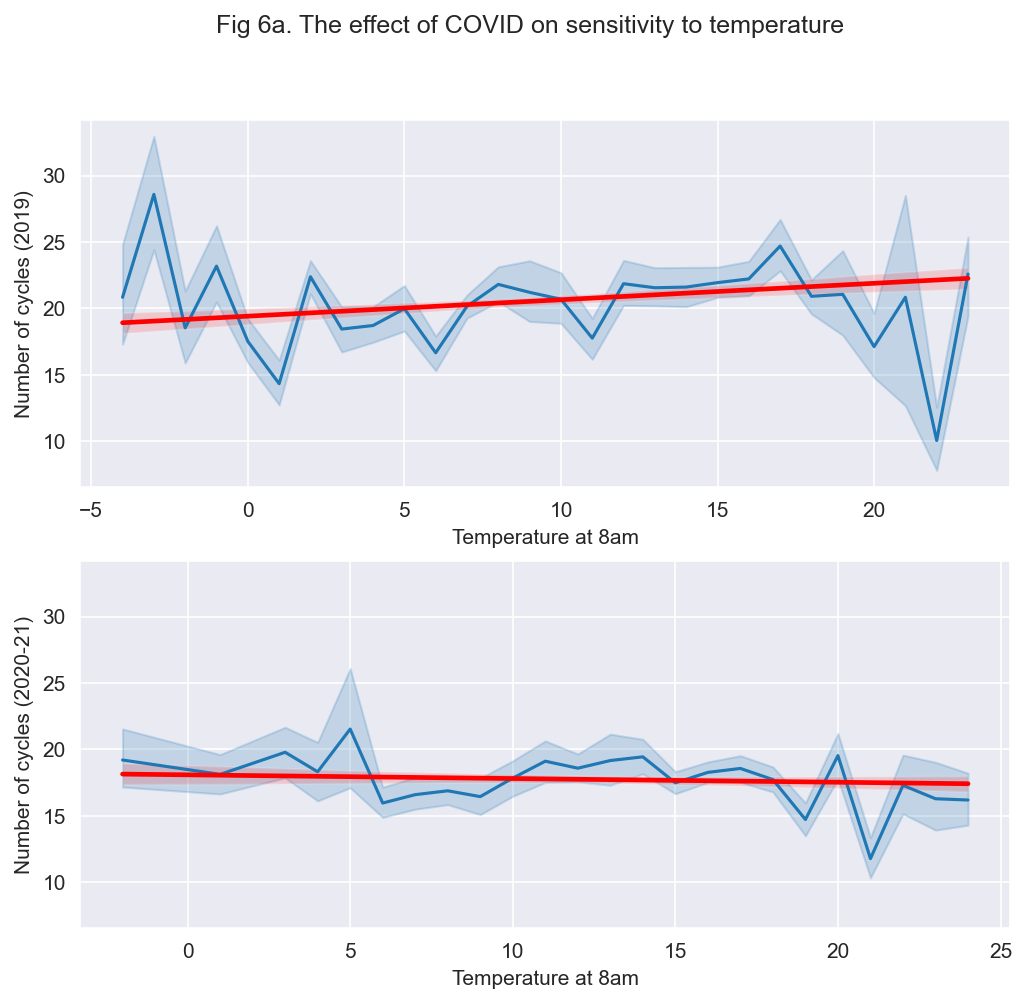

In [38]:
#Plotting differences in the counts of cycle trips by temperature for the two years. 

#Subset dataframe for 2019
df_dry_2019 = dry_filtered_AM_peak_trips[dry_filtered_AM_peak_trips['Year'] == 2019]

#Subset dataframe for 2020-21

start_date = pd.to_datetime('2020-07-01')
end_date = pd.to_datetime('2021-12-31')

mask = (dry_filtered_AM_peak_trips['Survey date'] >= start_date) & (dry_filtered_AM_peak_trips['Survey date'] <= end_date)
df_dry_2020_21 = dry_filtered_AM_peak_trips.loc[mask]

sns.set_palette(default_palette)
#Plot the results

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8,7), dpi=150, sharey=True)
sns.lineplot(x='temp_integer', y='Total cycles', data=df_dry_2019, ax=axs[0])
sns.regplot(x='temp_integer', y='Total cycles', data=df_dry_2019, scatter=False, color='red', ax=axs[0])
sns.lineplot(x='temp_integer', y='Total cycles', data=df_dry_2020_21, ax=axs[1])
sns.regplot(x='temp_integer', y='Total cycles', data=df_dry_2020_21, scatter=False, color='red', ax=axs[1])

fig.suptitle('Fig 6a. The effect of COVID on sensitivity to temperature')
axs[0].set_xlabel('Temperature at 8am')
axs[1].set_xlabel('Temperature at 8am')
axs[0].set_ylabel('Number of cycles (2019)')
axs[1].set_ylabel('Number of cycles (2020-21)')


After the arrival of COVID the regression line looks nearly flat, so temperature has almost no effect on cycling numbers. The slight downward slope in the regression could be because there is no Q1 data.

We need to compare 2019 with 2020-21. Plotting the difference in means for the two years was not clear enough to be meaningful, but a single mean of the difference in means is clear.

In [40]:


#Subset dataframe for 2019
df_2019 = AM_peak_trips[AM_peak_trips['Year'] == 2019]

#Subset dataframe for 2021
df_2020_21 = AM_peak_trips[AM_peak_trips['Year'] == 2021]

#2019

df_dry_2019 = df_2019[(df_2019['Weather'] == 0)]
mean_dry_2019 = df_dry_2019.groupby('temp_integer')['Total cycles'].mean().reset_index()

df_wet_2019 = df_2019[(df_2019['Weather'] == 1)]
mean_wet_2019 = df_wet_2019.groupby('temp_integer')['Total cycles'].mean().reset_index()

#Calculate difference in means between wet and dry conditions for 2019
mean_difference_2019 = mean_wet_2019.merge(mean_dry_2019, on='temp_integer', suffixes=('_wet', '_dry'))
mean_difference_2019['difference'] = mean_difference_2019['Total cycles_wet'] - mean_difference_2019['Total cycles_dry']

mean_of_mean_diff_2019 = np.mean(mean_difference_2019['difference'])
print('Drop in mean Total cycles on wet days (2019):', mean_of_mean_diff_2019)


Drop in mean Total cycles on wet days (2019): -12.940595930252002


In [42]:
#2021

df_dry_2020_21 = df_2020_21[(df_2020_21['Weather'] == 0)]
mean_dry_2020_21 = df_dry_2020_21.groupby('temp_integer')['Total cycles'].mean().reset_index()

df_wet_2020_21 = df_2020_21[(df_2020_21['Weather'] == 1)]
mean_wet_2020_21 = df_wet_2020_21.groupby('temp_integer')['Total cycles'].mean().reset_index()

#Calculate difference in means between wet and dry conditions for 2021
mean_difference_2020_21 = mean_wet_2020_21.merge(mean_dry_2020_21, on='temp_integer', suffixes=('_wet', '_dry'))
mean_difference_2020_21['difference'] = mean_difference_2020_21['Total cycles_wet'] - mean_difference_2020_21['Total cycles_dry']

mean_of_mean_diff_2020_21 = np.mean(mean_difference_2020_21['difference'])
print('Drop in mean Total cycles on wet days (2020-21):', mean_of_mean_diff_2020_21)


Drop in mean Total cycles on wet days (2020-21): -9.95324644140431


Percentage difference in mean cycle trips due to wet weather: 0.7691490017191568


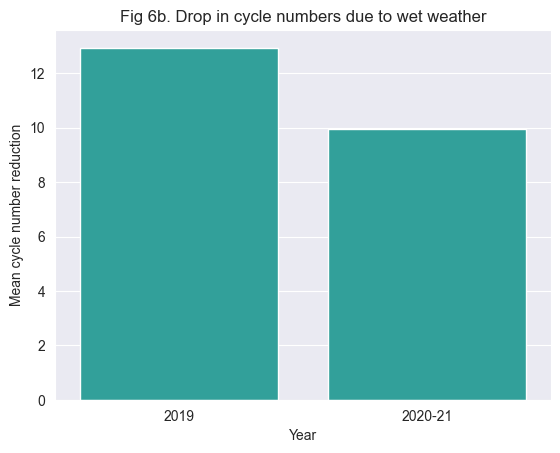

In [44]:

means = [-(mean_of_mean_diff_2019), -(mean_of_mean_diff_2020_21)]
labels = ('2019', '2020-21')
data = pd.DataFrame({'Year': labels, 'Mean cycle number reduction': means})

sns.barplot(x='Year', y='Mean cycle number reduction', data=data, color="lightseagreen")
plt.ylabel('Mean cycle number reduction')
plt.title('Fig 6b. Drop in cycle numbers due to wet weather')

print('Percentage difference in mean cycle trips due to wet weather:', mean_of_mean_diff_2020_21/mean_of_mean_diff_2019)


There is a similar smaller drop in cycle numbers in wet conditions after COVID.

## The effect of brown fat on cycling numbers in cold temperatures
For this analysis we need compare trip counts for the same temperatures as winter starts and as it ends, once the body has adapted to cold exposure.


Text(0, 0.5, 'Total cycles (Jan-Mar)')

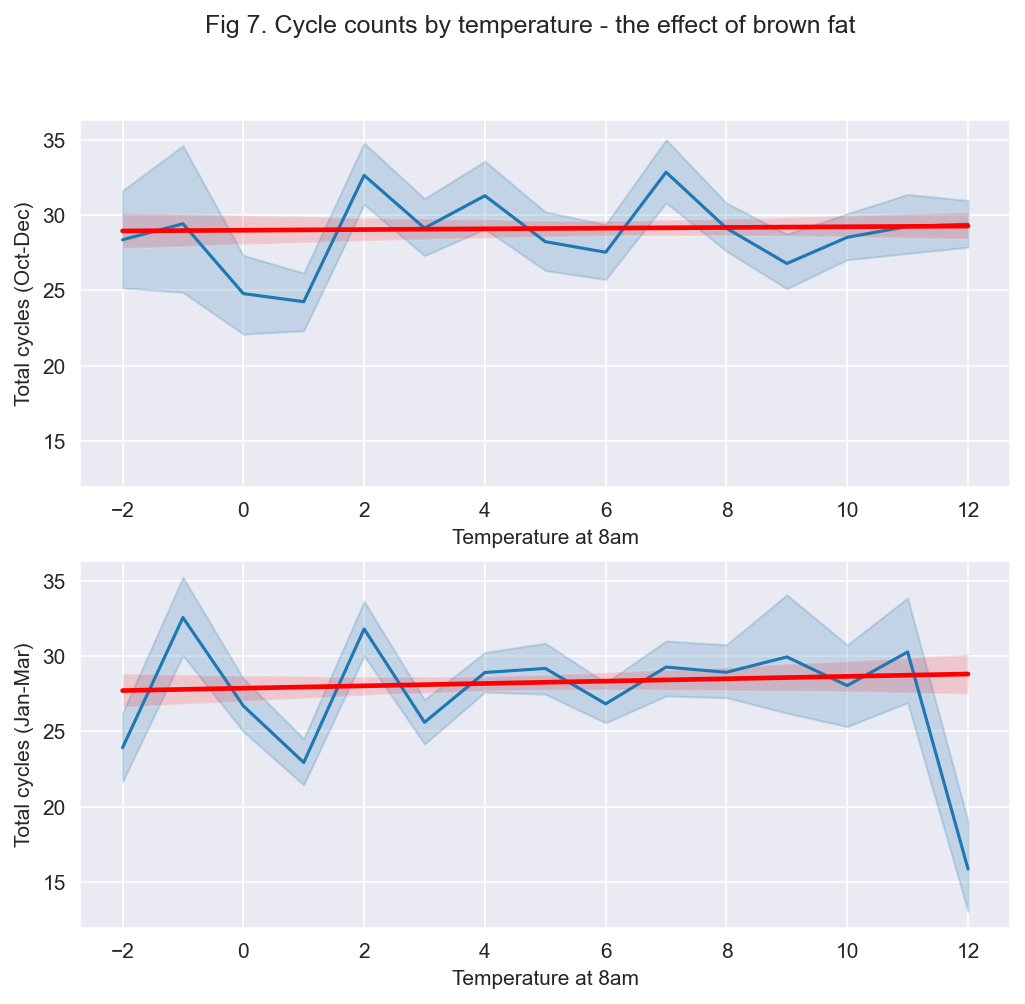

In [45]:
#Subset dataframe for October to December and January to March, dry days. Limited to max of 12 degrees 
#because 12.5 is limit in data for Jan-Mar. Limited to a min of -2 due to sample size, as above

trips_jan_mar = AM_peak_trips[AM_peak_trips['Survey date'].dt.month.isin([1,2,3]) & (AM_peak_trips['Weather'] == 0) & (AM_peak_trips['temp_integer'] >= -2) & (AM_peak_trips['temp_integer'] <= 12)]
trips_oct_dec = AM_peak_trips[AM_peak_trips['Survey date'].dt.month.isin([10,11,12]) & (AM_peak_trips['Weather'] == 0) & (AM_peak_trips['temp_integer'] >= -2) & (AM_peak_trips['temp_integer'] <= 12)]
                              
#Plotting the results

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8,7), dpi=150, sharey=True)

sns.lineplot(x='temp_integer', y='Total cycles', data=trips_jan_mar, ax=axs[1])
sns.regplot(x='temp_integer', y='Total cycles', data=trips_jan_mar, scatter=False, color='red', ax=axs[1])
sns.lineplot(x='temp_integer', y='Total cycles', data=trips_oct_dec, ax=axs[0])
sns.regplot(x='temp_integer', y='Total cycles', data=trips_oct_dec, scatter=False, color='red', ax=axs[0])

fig.suptitle('Fig 7. Cycle counts by temperature - the effect of brown fat')
axs[0].set_xlabel('Temperature at 8am')
axs[1].set_xlabel('Temperature at 8am')
axs[0].set_ylabel('Total cycles (Oct-Dec)')
axs[1].set_ylabel('Total cycles (Jan-Mar)')



The numbers are greater at the start than the end of winter – the reverse of what would be expected if brown fat made people more resilient to cold temperatures.